In [1]:
import os
import pandas as pd
import sys
sys.path.insert(0, os.path.abspath('../lib'))

import config
from evaluate import get_results, plot_confusion_matrix_multiclass, compute_plot_roc_multiclass

from sklearn.utils import shuffle, class_weight
import numpy as np

# Troubleshooting and visualisation
import IPython.display as ipd

# NB: clean up model output folder structure

In [2]:
# Extra imports
import feat_util
import librosa
import matplotlib.pyplot as plt

In [3]:
library = 'PyTorch'

if library == 'PyTorch':
    from PyTorch.runTorchMultiClass import train_model, load_model, evaluate_model, ResnetDropoutFull, Resnet, VGGishDropout
    from PyTorch import config_pytorch
elif library == 'Keras':
    from tensorflow import keras
    from Keras.runKeras import train_model, load_model, evaluate_model
else:
    print('Library:', library, 'not supported. Please add your own code for support of that framework.')

In [4]:
# Select IHI Tanzania cup data to use for multi-species classification

df = pd.read_csv(config.data_df)
idx_multiclass = np.logical_and(df['country'] == 'Tanzania', df['location_type'] == 'cup')
df_all = df[idx_multiclass]

In [5]:
# Select list of classes with sufficient samples for significant analysis. Ordered with similar groups in adjacent classes.

classes = ['an arabiensis','culex pipiens complex', 'ae aegypti','an funestus ss','an squamosus',
               'an coustani','ma uniformis','ma africanus']

# Create features (only re-run if not loading from pickle)

In [8]:
import collections
species_dict = collections.OrderedDict()
species_recordings = collections.OrderedDict()
for species in classes:
    # Number of total audio clips per species (includes repeats from same filename)
    species_recordings[species] = len(pd.unique(df_all[df_all.species==species].name)) # Number of unique audio recordings (and hence mosquitoes)
    species_dict[species] = sum(df_all[df_all.species==species].length)

In [9]:
# Divide recordings into train and test, with recording shuffling fixed by random_state
train_fraction = 0.75
train_recordings = {}
test_recordings = {}

# Random seeds for 5-fold CV results
random_seeds = [42, 21, 5, 10, 100] # Paper results so far use random_seed=42

random_seed = 42

for i in range(len(classes)):
    n_train = int(species_recordings[classes[i]] * train_fraction)
    n_test = species_recordings[classes[i]] - n_train
    print(classes[i], n_train, n_test)
    df_class = df_all[df_all.species == classes[i]]
    train_recordings[i] =  shuffle(pd.unique(df_class.name), random_state=random_seed)[:n_train]  
    test_recordings[i] = shuffle(pd.unique(df_class.name),random_state=random_seed)[n_train:]

an arabiensis 385 129
culex pipiens complex 252 84
ae aegypti 36 13
an funestus ss 186 62
an squamosus 68 23
an coustani 37 13
ma uniformis 57 19
ma africanus 28 10


In [ ]:
# Features for VGGish input: 96x64 (W*H) log-mel spectrogram
from feat_vggish import get_feat_multispecies
# Features for all other models using default log-mel implementation:
from feat_util

In [ ]:
from PyTorch.vggish.vggish_input import waveform_to_examples

def get_feat_multispecies(df_all, label_recordings_dict, data_dir, rate, n_feat):
    '''Extract features for multi-class species classification.'''
    X = []
    y = []

    for class_label in label_recordings_dict.keys(): # Loop over classes
        print('Extracting features for class:', class_label)
        for i in label_recordings_dict[class_label]: # Loop over recordings in class
            df_match = df_all[df_all.name == i]
            for idx, row in df_match.iterrows(): # Loop over clips in recording
                _, file_format = os.path.splitext(row['name'])
                filename = os.path.join(data_dir, str(row['id']) + file_format)
                signal, rate = librosa.load(filename, sr=rate)
                feat = waveform_to_examples(signal, rate)
                X.append(feat)
                y.append(class_label)
    return X, y

In [ ]:
def get_feat_multispecies(df_all, label_recordings_dict, data_dir, rate, n_feat):
    '''Extract features for multi-class species classification.'''
    X = []
    y = []

    for class_label in label_recordings_dict.keys(): # Loop over classes
        print('Extracting features for class:', class_label)
        for i in label_recordings_dict[class_label]: # Loop over recordings in class
            df_match = df_all[df_all.name == i]
            for idx, row in df_match.iterrows(): # Loop over clips in recording
                _, file_format = os.path.splitext(row['name'])
                filename = os.path.join(data_dir, str(row['id']) + file_format)
                signal, rate = librosa.load(filename, sr=rate)
                feat = librosa.feature.melspectrogram(signal, sr=rate, n_mels=n_feat) 
#                 feat = librosa.feature.mfcc(y=signal, sr=rate, n_mfcc=n_feat)
                feat = librosa.power_to_db(feat, ref=np.max)
                if config.norm_per_sample:
                    feat = (feat-np.mean(feat))/np.std(feat)                
                X.append(feat)
                y.append(class_label)
    return X, y

In [ ]:
# Run for VGGish:
X_test, y_test = get_feat_multispecies(df_all, test_recordings, config.data_dir, config.rate, config.n_feat)

In [ ]:
X_train, y_train = get_feat_multispecies(df_all, train_recordings, config.data_dir, config.rate, config.n_feat)

In [ ]:
X_test_CNN, y_test_CNN = reshape_feat(X_test, y_test)

In [ ]:
X_train_CNN, y_train_CNN = reshape_feat(X_train, y_train)

In [ ]:
import torch
def reshape_feat(feats, labels):
    y_full = []
    for idx, feat in enumerate(feats):
        y_full.append(np.repeat(labels[idx], np.shape(feat)[0]))
    y = np.concatenate(y_full)

    x = torch.cat(feats, 0)
    y = torch.tensor(y).float() 
    return x, y

In [ ]:
# Save feature output to pickle VGGish

import pickle
pickle_name_train = 'vggish_' + str(random_seed) + '_train.pickle'
pickle_name_test = 'vggish_' + str(random_seed) + '_test.pickle'

feat_train = {"X_train":X_train_CNN, "y_train":y_train_CNN}
feat_test = {"X_test":X_test_CNN, "y_test":y_test_CNN}


dir_out = '../outputs/features/multi-species/humbugdb'
with open(os.path.join(dir_out, pickle_name_train), 'wb') as f:
    pickle.dump(feat_train, f, protocol=4)
    print('Saved features to:', os.path.join(dir_out, pickle_name_train))
    
with open(os.path.join(dir_out, pickle_name_test), 'wb') as f:
    pickle.dump(feat_test, f, protocol=4)
    print('Saved features to:', os.path.join(dir_out, pickle_name_test))   

In [10]:
# Load VGGish pickle

import pickle
dir_out = '../outputs/features/multi-species/humbugdb'
pickle_name_train = 'vggish_' + str(random_seed) + '_train.pickle'
pickle_name_test = 'vggish_' + str(random_seed) + '_test.pickle'


with open(os.path.join(dir_out, pickle_name_train), 'rb') as input_file:
    feat_train = pickle.load(input_file)
    
with open(os.path.join(dir_out, pickle_name_test), 'rb') as input_file:
    feat_test = pickle.load(input_file)
    
X_train = feat_train["X_train"]
y_train = feat_train["y_train"]
X_test = feat_test["X_test"]
y_test = feat_test["y_test"]
# Returns features with correct dimensions for VGGish16.


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.imshow(X_train[400].detach().numpy().squeeze().T)
plt.colorbar()

In [ ]:
# Extract feats, expected runtime ~5 mins
X_test, y_test = get_feat_multispecies(df_all, test_recordings, config.data_dir, config.rate, config.n_feat)
# Extract feats, expected runtime ~14 mins
X_train, y_train = get_feat_multispecies(df_all, train_recordings, config.data_dir, config.rate, config.n_feat)

# Save features to pickle

In [ ]:
# Save feature output to pickle

import pickle
pickle_name_train = 'log_mel_feat_shuffle_' + str(random_seed) + '_train_norm_'+str(config.norm_per_sample)+'.pickle'
pickle_name_test = 'log_mel_feat_shuffle_' + str(random_seed) + '_test_norm_'+str(config.norm_per_sample)+'.pickle'

log_mel_feat_train = {"X_train":X_train, "y_train":y_train}
log_mel_feat_test = {"X_test":X_test, "y_test":y_test}


dir_out = '../outputs/features/multi-species/humbugdb'
with open(os.path.join(dir_out, pickle_name_train), 'wb') as f:
    pickle.dump(log_mel_feat_train, f, protocol=4)
    print('Saved features to:', os.path.join(dir_out, pickle_name_train))
    
with open(os.path.join(dir_out, pickle_name_test), 'wb') as f:
    pickle.dump(log_mel_feat_test, f, protocol=4)
    print('Saved features to:', os.path.join(dir_out, pickle_name_test))   

# Load pickled features

In [ ]:
# Load pickle

import pickle
dir_out = '../outputs/features/multi-species/humbugdb'
pickle_name_train = 'log_mel_feat_shuffle_' + str(random_seed) + '_train_norm_'+str(config.norm_per_sample)+'.pickle'
pickle_name_test = 'log_mel_feat_shuffle_' + str(random_seed) + '_test_norm_'+str(config.norm_per_sample)+'.pickle'


with open(os.path.join(dir_out, pickle_name_train), 'rb') as input_file:
    log_mel_feat_train = pickle.load(input_file)
    
with open(os.path.join(dir_out, pickle_name_test), 'rb') as input_file:
    log_mel_feat_test = pickle.load(input_file)
    
X_train = log_mel_feat_train["X_train"]
y_train = log_mel_feat_train["y_train"]
X_test = log_mel_feat_test["X_test"]
y_test = log_mel_feat_test["y_test"]
# Reshape features to be used with CNN (Keras or PyTorch)

X_train_CNN, y_train_CNN = feat_util.reshape_feat(X_train, y_train, config.win_size, config.step_size)
X_test_CNN, y_test_CNN = feat_util.reshape_feat(X_test, y_test, config.win_size, config.win_size)

# Model definition and optimisation
Current model here is identical to the model used in paper for previous results with binary mosquito/noise detection. Acts as good baseline for further work.

In [ ]:
class_weights = class_weight.compute_class_weight('balanced',classes=np.unique(y_train_CNN),y=y_train_CNN)

In [ ]:
class_weights = class_weight.compute_class_weight('balanced',classes=np.unique(np.array(y_train)),y=np.array(y_train))
model = train_model(X_train, y_train, class_weight = class_weights, model = VGGishDropout(n_classes = 8, dropout=0.2))

F:\PostdocCode\HumBugDB\lib\PyTorch\runTorchMultiClass.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_train).float()
F:\PostdocCode\HumBugDB\lib\PyTorch\runTorchMultiClass.py:97: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.long)


Training on cuda:0
Applying class weights: [0.31523012 0.57031123 3.6119711  0.62266501 2.26830849 4.31565968
 2.71317829 6.6539924 ]
all_y all_y_pred (28000, 1) (28000,)
Saving model to: ..\outputs\models\pytorch\model_e0_2021_08_05_12_44_59.pth
Epoch: 0, Train Loss: 2.04417420, Train Acc: 0.30657143, overrun_counter 0
all_y all_y_pred (28000, 1) (28000,)
Saving model to: ..\outputs\models\pytorch\model_e1_2021_08_05_12_48_26.pth
Epoch: 1, Train Loss: 1.62546576, Train Acc: 0.38732143, overrun_counter 0
all_y all_y_pred (28000, 1) (28000,)
Saving model to: ..\outputs\models\pytorch\model_e2_2021_08_05_12_51_52.pth
Epoch: 2, Train Loss: 1.34184446, Train Acc: 0.44764286, overrun_counter 0
all_y all_y_pred (28000, 1) (28000,)
Saving model to: ..\outputs\models\pytorch\model_e3_2021_08_05_12_55_16.pth
Epoch: 3, Train Loss: 1.17417468, Train Acc: 0.50796429, overrun_counter 0
all_y all_y_pred (28000, 1) (28000,)
Saving model to: ..\outputs\models\pytorch\model_e4_2021_08_05_12_58_40.pth
E

all_y all_y_pred (28000, 1) (28000,)
Epoch: 52, Train Loss: 0.11563157, Train Acc: 0.96628571, overrun_counter 9
all_y all_y_pred (28000, 1) (28000,)
Epoch: 53, Train Loss: 0.13066679, Train Acc: 0.95750000, overrun_counter 10
all_y all_y_pred (28000, 1) (28000,)
Epoch: 54, Train Loss: 0.15924130, Train Acc: 0.95067857, overrun_counter 11
all_y all_y_pred (28000, 1) (28000,)
Epoch: 55, Train Loss: 0.11987878, Train Acc: 0.96542857, overrun_counter 12
all_y all_y_pred (28000, 1) (28000,)
Epoch: 56, Train Loss: 0.11947037, Train Acc: 0.96460714, overrun_counter 13


In [ ]:
class_weights = class_weight.compute_class_weight('balanced',classes=np.unique(np.array(y_train)),y=np.array(y_train))
model = train_model(X_train, y_train, class_weight = class_weights, model = Resnet(n_classes = 8, dropout=0.2))

In [ ]:
# model = train_model(X_train_CNN, y_train_CNN, class_weight = class_weights)
model = train_model(X_train_CNN, y_train_CNN, class_weight = class_weights, model = Resnet(n_classes = 8, dropout=0.2))

In [ ]:
# Compute class weights to weight by inverse of class frequency
# weights = torch.tensor(class_weights)  # Torch does not use dict for class weights
# class_weights = dict(enumerate(class_weights.flatten()))  # Dict to support both older and newer Keras API

# Load model from checkpoint
## (optional)

In [ ]:
# Select checkpoint to load model (optional)
# Following filepath used for results on 26/07/: model results from paper
filepath = '../outputs/models/keras_Multiclass/Win_30_Stride_5_2021_07_26_12_59_05-e80accuracy0.9635.hdf5'

# ResNet-50 BNN
# filepath = '../outputs/models/pytorch/model_e72_2021_07_29_22_10_30.pth'

#30th July overnight training:
filepath = '../outputs/models/pytorch/model_e91_2021_07_30_05_40_54.pth'

# 30th July day training ResNet-18 BNN
filepath = '../outputs/models/pytorch/model_e83_2021_07_30_20_45_11.pth'


# VGGish16:
# fIRST poor attempt. model_e10_2021_08_04_22_39_37.pth


# 31st July 2 AM Next random seed: 21
filepath = '../outputs/models/pytorch/model_e78_2021_07_31_02_00_40.pth'
filepath = '../outputs/models/keras/Win_30_Stride_5_2021_07_31_02_31_05-e77accuracy0.9633.hdf5'
# Resnet50: model_e14_2021_08_03_11_51_30.pth'

# 31st July 2:30-3:30 AM, random seed: 5
filepath = '../outputs/models/keras/Win_30_Stride_5_2021_07_31_03_25_35-e69accuracy0.9608.hdf5'
# second option: filepath = Win_30_Stride_5_2021_08_03_00_07_38-e43accuracy0.9621.hdf5 # 
#ResNet18:
# Training started 17:48 31/07: dropout 0.05 inside, 0.2 outside:
filepath = '../outputs/models/pytorch/model_e77_2021_07_31_20_01_44.pth'


# Training at 14:55 02/08, dropout 0.2 fixed
filepath = '../outputs/models/pytorch/model_e98_2021_08_02_15_00_40.pth'

# ResNet18 0.05 dropout everywhere
filepath = '../outputs/models/pytorch/model_e98_2021_08_02_18_44_03.pth'



#ResNet50
filepath = '../outputs/models/pytorch/model_e71_2021_08_01_04_23_48.pth'
#ResNet50NoDropout (run 1, collapsed after this epoch)
filepath = '../outputs/models/pytorch/model_e73_2021_08_01_18_19_10.pth'
#ResNet50NoDropout (run 2, ensured code correct for this rim)
filepath = '../outputs/models/pytorch/model_e91_2021_08_02_01_26_12.pth' 
# 02/aug/21 2:06 AM


#random seed: 10
#Keras:
filepath = '../outputs/models/keras/Win_30_Stride_5_2021_08_03_09_42_31-e60accuracy0.9614.hdf5'

# ResNet18:
filepath = '../outputs/models/pytorch/model_e86_2021_08_02_22_14_16.pth'
#ResNet50
# very poor: dropout 0.2 fixed loss: model_e68_2021_08_03_07_04_28.pth

# random seed 100
# Keras:
filepath = '../outputs/models/keras/Win_30_Stride_5_2021_07_31_13_20_53-e68accuracy0.9601.hdf5'
#ResNet18:
filepath = '../outputs/models/keras/model_e99_2021_07_31_16_58_14.pth'

#ResNet50 (dropout last layer strictly only)
# training now: 02 Aug 21, started 2:08 AM
filepath = '../outputs/models/pytorch/model_e85_2021_08_02_07_17_14.pth'




model = load_model(filepath)


In [12]:
filepath = '../outputs/models/pytorch/model_e40_2021_08_05_15_02_37.pth'
# filepath = '../outputs/models/keras/Win_30_Stride_5_2021_08_03_09_42_31-e60accuracy0.9614.hdf5'
model = load_model(filepath, model=VGGishDropout(n_classes=8))

Training on cuda:0


In [13]:
random_seed

42

# Predict and visualise

Evaluating on cuda:0


F:\PostdocCode\HumBugDB\lib\PyTorch\runTorchMultiClass.py:297: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
F:\PostdocCode\HumBugDB\lib\PyTorch\runTorchMultiClass.py:301: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test).float()


0.5295727215323089
0.5295727215323089
BNN sampled
              precision    recall  f1-score   support

         0.0       0.63      0.65      0.64      3806
         1.0       0.50      0.37      0.43      2020
         2.0       0.58      0.21      0.31       353
         3.0       0.60      0.71      0.65      1866
         4.0       0.23      0.28      0.25       549
         5.0       0.30      0.23      0.26       318
         6.0       0.21      0.37      0.27       346
         7.0       0.24      0.17      0.20       244

    accuracy                           0.53      9502
   macro avg       0.41      0.37      0.37      9502
weighted avg       0.53      0.53      0.52      9502



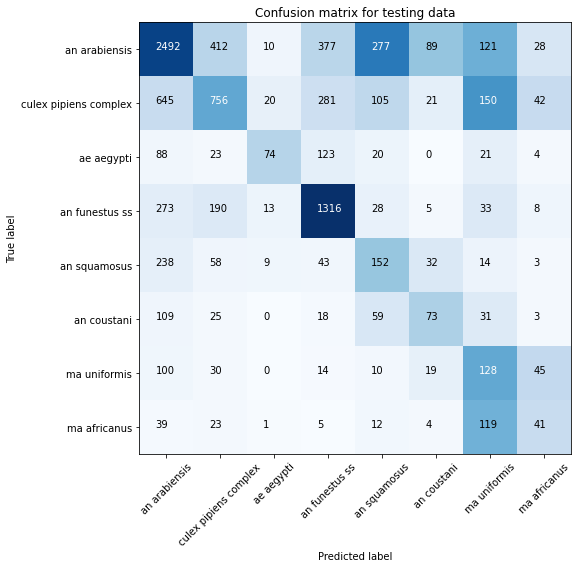

In [14]:
preds_list = evaluate_model(model, X_test, y_test, 2)

print('BNN sampled')
from sklearn.metrics import classification_report,confusion_matrix

cnf_matrix = confusion_matrix(y_test, np.argmax(np.mean(preds_list,axis=0), axis=1))
plot_confusion_matrix_multiclass(cnf_matrix, 'Confusion matrix for testing data', classes)
print(classification_report(y_test, np.argmax(np.mean(preds_list,axis=0), axis=1)))

BNN
{0: 0.7134657790109644, 1: 0.723356418440561, 2: 0.8755244075344384, 3: 0.8298432089886177, 4: 0.7863717364736347, 5: 0.7897902833475776, 6: 0.8265334080813744, 7: 0.853050883772652, 'micro': 0.8355909171657906}


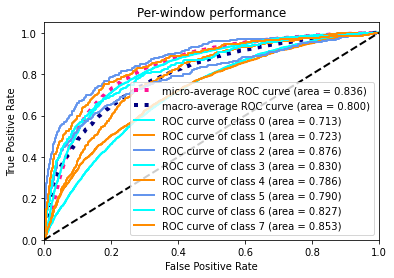

In [16]:
compute_plot_roc_multiclass(y_test, np.mean(preds_list,axis=0), classes, title='Per-window performance')

In [ ]:
preds_list = evaluate_model(model, X_test_CNN, y_test_CNN, 100)

In [ ]:
# Good morning me, random seed 10 on Keras here!

In [ ]:
print('BNN sampled')
from sklearn.metrics import classification_report,confusion_matrix

cnf_matrix = confusion_matrix(y_test_CNN, np.argmax(np.mean(preds_list,axis=0), axis=1))
plot_confusion_matrix_multiclass(cnf_matrix, 'Confusion matrix for testing data', classes)
print(classification_report(y_test_CNN, np.argmax(np.mean(preds_list,axis=0), axis=1)))

In [ ]:
import sklearn
from evaluate import to_categorical
# debug multi ROC:

y_pred_prob = np.mean(preds_list,axis=0)
y_true = y_test_CNN

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(classes)):
    fpr[i], tpr[i], thresholds = sklearn.metrics.roc_curve(to_categorical(y_true)[:, i], y_pred_prob[:, i])
    roc_auc[i] = sklearn.metrics.auc(fpr[i], tpr[i])
    

fig, axes = plt.subplots(4,2, figsize=(10,10))
for species_idx, ax in enumerate(axes.ravel()):
    ax.plot(to_categorical(y_true)[:,species_idx],'.',label='Target')
    ax.plot(y_pred_prob[:,species_idx], label='Prediction',lw=1)
    ax.set_title('Class: ' + classes[species_idx] + ' ROC: ' + '{:.2f}'.format(roc_auc[species_idx]))
    ax.legend()
plt.tight_layout()

In [15]:
compute_plot_roc_multiclass(y_test_CNN, np.mean(preds_list,axis=0), classes, title='Per-window performance')

NameError: name 'y_test_CNN' is not defined

In [ ]:
filepath

In [ ]:
random_seed

In [ ]:
# For now we can just save a copy paste of results, but let's write a func to store results for random seed

# Random seed 42:
#Keras filepath = '../outputs/models/keras_Multiclass/Win_30_Stride_5_2021_07_26_12_59_05-e80accuracy0.9635.hdf5'
#% Results: model_e91_2021_07_30_05_40_54.pth ResNet50, N=100 samples.
#% model_e96_2021_07_30_21_07_26.pth ResNet18, N=100

########################################################################################################################################
# Random seed 21:
resnet_18_21 = {0: 0.907429826653944, 1: 0.9018660114354919, 2: 0.9772856383871792, 3: 0.975732819039722, 4: 0.9157321333198608, 5: 0.9043455991405537, 6: 0.8711321300741771, 7: 0.8655805677916948, 'micro': 0.9490051251978446}
# pytorch/model_e78_2021_07_31_02_00_40.pth

resnet_50_21 = {0: 0.8208432729007634, 1: 0.8115046638640783, 2: 0.9757929671957332, 3: 0.7947146706941483, 4: 0.8562466619512968, 5: 0.8373920938545786, 6: 0.6791755511030099, 7: 0.8306014955087708, 'micro': 0.8778591332615912}
#filepath = '../outputs/models/pytorch/model_e14_2021_08_03_11_51_30.pth'

# Keras Win_30_Stride_5_2021_07_31_02_31_05-e77accuracy0.9633.hdf5
keras_21 = {0: 0.8502981870229007, 1: 0.849051739196255, 2: 0.9469929230365854, 3: 0.9322344132512044, 4: 0.8140991959813502, 5: 0.8432175996349256, 6: 0.7260914040189472, 7: 0.8877960840870969, 'micro': 0.9110295743205659}

########################################################################################################################################
# Random seed 5 (extremeeeeeely high??):
# ResNet18: /model_e77_2021_07_31_20_01_44.pth'
resnet_18_5 = {0: 0.9229526271868468, 1: 0.9368816597520596, 2: 0.963522226188537, 3: 0.9485264392064245, 4: 0.9683964598097428, 5: 0.9573003617307201, 6: 0.9424164608703435, 7: 0.9598949535472974, 'micro': 0.9633259373270477}
# keras: Win_30_Stride_5_2021_07_31_03_25_35-e69accuracy0.9608.hdf5'
keras_5 = {0: 0.8651004342867288, 1: 0.8811829533956251, 2: 0.9773862293400246, 3: 0.9034032187347225, 4: 0.8367226904169062, 5: 0.9099093024039921, 6: 0.8506791500190954, 7: 0.9154296875, 'micro': 0.9292624736481938}


#ResNet18 (dropout 0.2 everywhere), possibly just needs longer training...
#filepath = '../outputs/models/pytorch/model_e98_2021_08_02_15_00_40.pth'
# {0: 0.8550957508550351, 1: 0.849406683341789, 2: 0.9878116685901368, 3: 0.8979362164388284, 4: 0.829748850794867, 5: 0.9049481487190109, 6: 0.8161319506655927, 7: 0.7439875422297298, 'micro': 0.9176793014248503}


# 0.05 dropout everywhere
#filepath = 'model_e61_2021_08_02_17_29_50.pth'
# {0: 0.8517884463301456, 1: 0.851428843445032, 2: 0.9763095481520246, 3: 0.9045281929952107, 4: 0.8478659899125327, 5: 0.9192744834539904, 6: 0.817371602145421, 7: 0.8095663534628378, 'micro': 0.9137075568633347}


# ResNet 50, dropout full:
#model_e71_2021_08_01_04_23_48.pth'
# Poor training: {0: 0.8332316233468624, 1: 0.7640107082102523, 2: 0.959236873327072, 3: 0.8714290717106304, 4: 0.8300273734278235, 5: 0.7736509756132806, 6: 0.8295829224052605, 7: 0.7226958403716216, 'micro': 0.8824963879596882}
# ResNet 50, dropout last layer
# (run 1, collapsed after this epoch)
#filepath = '../outputs/models/pytorch/model_e73_2021_08_01_18_19_10.pth'
resnet_50_5 = {0: 0.84578597629865, 1: 0.8407899204043909, 2: 0.928063949317428, 3: 0.8699658067218299, 4: 0.8382569590755282, 5: 0.8560398433624098, 6: 0.800616813005796, 7: 0.7546056798986488, 'micro': 0.9056548177487792}
#ResNet50 without collapse:
#model_e91_2021_08_02_01_26_12.pth
#{0: 0.817411216577308, 1: 0.8262646263379168, 2: 0.9617859044872884, 3: 0.8675373975847583, 4: 0.80610475324012, 5: 0.8663555108141912, 6: 0.7648729379385633, 7: 0.6695101351351351, 'micro': 0.8957878697333836}

########################################################################################################################################
# Random seed 10:
#Keras: filepath = '../outputs/models/keras/Win_30_Stride_5_2021_08_03_09_42_31-e60accuracy0.9614.hdf5
keras_10 = {0: 0.868455920254975, 1: 0.8615702636961775, 2: 0.9730785705361976, 3: 0.9308562976176432, 4: 0.851296768808193, 5: 0.9104649063525007, 6: 0.8836303162526624, 7: 0.9001826570333948, 'micro': 0.9318593580434757}

#ResNet18 fixed loss 0.05 dropout
filepath = '../outputs/models/pytorch/model_e28_2021_08_02_20_16_25.pth'
resnet_18_10 = {0: 0.7840781397344898, 1: 0.8421399387425842, 2: 0.9569429654175418, 3: 0.8797721353575868, 4: 0.853519557413038, 5: 0.9015866473028914, 6: 0.8547976861542096, 7: 0.9095814714112069, 'micro': 0.8957285991184005}

########################################################################################################################################
# Keras: # random seed 100
#filepath = '../outputs/models/keras/Win_30_Stride_5_2021_07_31_13_20_53-e68accuracy0.9601.hdf5'
keras_100 = {0: 0.8783979335446752, 1: 0.8606896208591721, 2: 0.9723285337141679, 3: 0.9163527200878863, 4: 0.8784291728885104, 5: 0.8653711484593838, 6: 0.7928047235881388, 7: 0.9454135230293885, 'micro': 0.9291024226844671}

# PyTorch ResNet18: model_e99_2021_07_31_16_58_14.pth
resnet_18_100 = {0: 0.8471517200892333, 1: 0.8359428490084403, 2: 0.9607714223098839, 3: 0.9048423292005864, 4: 0.8631383864390335, 5: 0.8048531339141162, 6: 0.840628259573834, 7: 0.8854465761299131, 'micro': 0.9143897312093303}

# PyTorch ResNet50 0 dropout module, but 0.2 on last layer:
# model_e85_2021_08_02_07_17_14.pth
resnet_50_100 = {0: 0.8713980979218034, 1: 0.8770412006241388, 2: 0.9334606168533831, 3: 0.8957214466894431, 4: 0.8724145133402227, 5: 0.7778289067920746, 6: 0.8119500633288631, 7: 0.8704534023137172, 'micro': 0.9191073388359018}



In [ ]:
resnet_18_42 = {0: 0.846, 1: 0.843, 2: 0.937, 3: 0.928, 4: 0.825, 5: 0.762, 6: 0.796, 7: 0.833, 'micro':0.910} # from paper
keras_42 = {0: 0.865, 1: 0.881, 2: 0.959, 3: 0.935, 4: 0.874, 5: 0.886, 6: 0.849, 7: 0.934, 'micro':0.933}
resnet_50_42 = {0: 0.841, 1: 0.849, 2: 0.933, 3: 0.919, 4: 0.847, 5: 0.811, 6: 0.837, 7: 0.869, 'micro':0.913}

In [ ]:
import pandas as pd
df_50 = pd.DataFrame([resnet_50_42, resnet_50_21, resnet_50_5, resnet_50_10, resnet_50_100])
df_18 = pd.DataFrame([resnet_18_42, resnet_18_21, resnet_18_5, resnet_18_10, resnet_18_100])
df_keras = pd.DataFrame([keras_42, keras_21, keras_5, keras_10, keras_100])

In [ ]:
pd.DataFrame([df_18.mean(), df_18.std()])

In [ ]:
pd.DataFrame([df_keras.mean(), df_keras.std()])

## Evaluate mean + std over xval splits

In [ ]:
# Supported for both Keras and PyTorch but requires separate kernel instances.
results_dict = {}

def evaluate_xval(filepaths, X_test_CNN, y_test_CNN, N_samples)
    for filepath in filepaths:
        model = load_model(filepath)
        preds_list = evaluate_model(model, X_test_CNN, y_test_CNN, N_samples)
        roc = compute_plot_roc_multiclass(y_test_CNN, np.mean(preds_list,axis=0), classes, title='Per-window performance')
        cnf_matrix = confusion_matrix(y_test_CNN, np.argmax(np.mean(preds_list,axis=0), axis=1))
        results_dict[filepath] = [cnf_matrix, roc]
    return results_dict
    


# Evaluate performance per recording (extension)

In [ ]:
def evaluate_aggregate_predictions(X_test, y_test, model, BNN_samples):
    '''Produce a decision of mosquito type per recording based on taking the mean of predictions over strided features as in 
    feat_util.reshape_feat. By default uses config.win_size and config.step_size as parameters for feature windowing.'''
    preds_aggregated_by_mean = []
    y_aggregated_prediction_by_mean = []
    
    for idx, recording in enumerate(X_test):
        preds_list = []
        X_item, _ = feat_util.reshape_feat([recording], [y_test[idx]], config.win_size, config.step_size)
        for i in range(BNN_samples):
            preds_values = model.predict(X_item)
            preds_list.append(preds_values)
        preds_values = np.mean(preds_list,axis=0)
    #     G_X, U_X, _ = active_BALD(np.log(preds_list), X_item, 8)

        preds_max = np.amax(preds_values, axis=1)
        preds = np.argmax(preds_values, axis=1)
        y_aggregated_prediction_by_mean.append(np.argmax(np.mean(preds_values, axis=0)))
        preds_aggregated_by_mean.append(np.mean(preds_values, axis=0))
    return preds_aggregated_by_mean, y_aggregated_prediction_by_mean

In [ ]:
preds_aggregated_by_mean, y_aggregated_prediction_by_mean = evaluate_aggregate_predictions(X_test, y_test, model, 100)

In [ ]:
cnf_matrix = confusion_matrix(y_test, y_aggregated_prediction_by_mean)
plot_confusion_matrix_multiclass(cnf_matrix, 'Confusion matrix for aggregated data per recording', classes)
print(classification_report(y_test, y_aggregated_prediction_by_mean))

In [ ]:
compute_plot_roc_multiclass(y_test,np.array(preds_aggregated_by_mean), classes, title='Per-recording performance')